In [1]:
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torchvision.transforms as transforms
import torchvision.models as models
import itertools

%matplotlib inline

In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [3]:
imsize = 512 if use_cuda else 128  

loader = transforms.Compose([
  transforms.Resize(imsize), 
  transforms.ToTensor()])  

def image_loader(image_name):
  image = Image.open(image_name)
  image = Variable(loader(image))
  image = image.unsqueeze(0)
  return image

style_img = image_loader("images/picasso.jpg").type(dtype)
content_img = image_loader("images/dancing.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

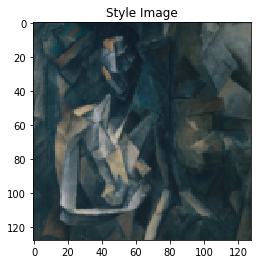

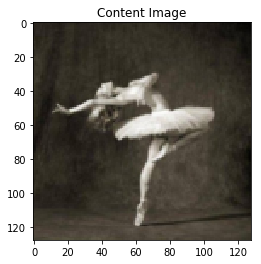

In [4]:
unloader = transforms.ToPILImage() 

# plt.ion()

def imshow(tensor, title=None):
  image = tensor.clone().cpu()  
  image = image.squeeze(0)
  image = unloader(image)
  plt.imshow(image)
  if title is not None:
      plt.title(title)
#   plt.pause(0.001) 

plt.figure()
imshow(style_img.data, title='Style Image')

plt.figure()
imshow(content_img.data, title='Content Image')

In [5]:
def compute_content_loss(x, y, weight):
  return F.mse_loss(x * weight, y * weight)
  
def compute_style_loss(x, y, weight):
  x_gram = gram_matrix(x) 
  y_gram = gram_matrix(y) 
  
  return F.mse_loss(x_gram * weight, y_gram * weight)

def gram_matrix(x):
  b, c, h, w = x.size()
  x = x.view(b * c, h * w)  
  G = torch.mm(x, x.t())  
  return G.div(b * c * h * w)

def compute_losses(input_features, target_features, content_weight, style_weight):
  input_content_features, input_style_features = input_features
  target_content_features, target_style_features = target_features
  
  assert len(input_content_features) == len(target_content_features)
  assert len(input_style_features) == len(target_style_features)
  
  content_loss = 0
  style_loss = 0
  
  content_loss = itertools.starmap(
    lambda x, y: compute_content_loss(x, y, content_weight), 
    zip(input_content_features, target_content_features),
  )
  content_loss = sum(content_loss)
  
  style_loss = itertools.starmap(
    lambda x, y: compute_style_loss(x, y, style_weight), 
    zip(input_style_features, target_style_features),
  )
  style_loss = sum(style_loss)
  
  return content_loss, style_loss

In [6]:
class Extractor(nn.Module):
  def __init__(self, model):
    super().__init__()
    self.model = model
    
  def forward(self, x, content_layer_names, style_layer_names):
    max_depth = len(content_layer_names) + len(style_layer_names)
    content_features = []
    style_features = []
    
    i = 0
    for layer in self.model:
      x = layer(x)
      
      if isinstance(layer, nn.Conv2d):
        name = 'conv_{}'.format(i)
        if name in content_layer_names:
          content_features.append(x)
        if name in style_layer_names:
          style_features.append(x)
        
      if isinstance(layer, nn.ReLU):
        i += 1
        
      if len(content_features) + len(style_features) == max_depth:
        break
      
    assert len(content_features) + len(style_features) == max_depth
    return content_features, style_features

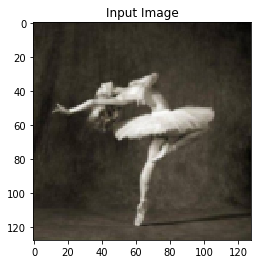

In [7]:
input_img = Variable(content_img.data.clone(), requires_grad=True).type(dtype)

plt.figure()
imshow(input_img.data, title='Input Image')

In [8]:
def run_style_transfer(extractor, content_img, style_img, input_img, steps, style_weight, content_weight):
  print('Building the style transfer model...')

  content_layer_names = ['conv_4']
  style_layer_names = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

  content_features, _ = extractor(content_img, content_layer_names, style_layer_names)
  _, style_features = extractor(style_img, content_layer_names, style_layer_names)

  optimizer = optim.Adam([input_img])

  print('Optimizing...')

  step = 0
  while step < steps:
    optimizer.zero_grad()

    input_features = extractor(input_img, content_layer_names, style_layer_names)
    content_loss, style_loss = compute_losses(
      input_features, 
      (content_features, style_features),
      content_weight,
      style_weight,
    )

    loss = content_loss + style_loss
    loss.backward()

    step += 1
    if step % 50 == 0:
      print('step: {}\nstyle loss: {:4f}, content loss: {:4f}'.format(
        step,
        style_loss.data[0], 
        content_loss.data[0],
      ))

    optimizer.step()
    input_img.data.clamp_(0, 1)

  return input_img.data

In [9]:
vgg = models.vgg19(pretrained=True).features

for param in vgg.parameters():
  param.requires_grad = False

if use_cuda:
  vgg = cnn.cuda()

Building the style transfer model...
Optimizing...
step: 50
style loss: 9.468544, content loss: 0.507319
step: 100
style loss: 4.586919, content loss: 0.602712
step: 150
style loss: 3.037306, content loss: 0.659697
step: 200
style loss: 2.300693, content loss: 0.698177
step: 250
style loss: 1.890284, content loss: 0.722778
step: 300
style loss: 1.626852, content loss: 0.740022
step: 350
style loss: 1.440070, content loss: 0.752526
step: 400
style loss: 1.300462, content loss: 0.761865
step: 450
style loss: 1.192446, content loss: 0.769364
step: 500
style loss: 1.104734, content loss: 0.775369
step: 550
style loss: 1.033014, content loss: 0.780234
step: 600
style loss: 0.972750, content loss: 0.783785
step: 650
style loss: 0.920861, content loss: 0.786704
step: 700
style loss: 0.875492, content loss: 0.789291
step: 750
style loss: 0.835796, content loss: 0.791289
step: 800
style loss: 0.800452, content loss: 0.792860
step: 850
style loss: 0.768360, content loss: 0.794177
step: 900
style

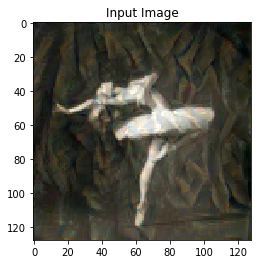

In [10]:
extractor = Extractor(vgg)

input_img = run_style_transfer(
  extractor, 
  content_img, 
  style_img, 
  input_img, 
  steps=1000,
  style_weight=1000, 
  content_weight=1,
)

plt.figure()
imshow(input_img, title='Input Image')

# sphinx_gallery_thumbnail_number = 4
# plt.ioff()
plt.show()